# Celltypist Confidence score analyisis

Celltypist is a deep-learning based Cell type prediction model. It takes transcript counts from important genes as input and predicts a cell type as output. Alson gwith the cell type prediction, celltypist provides confidence scores corresponding to the predictions. These can be used to asess the confidence of the mapping as well as to find cell groups where the model struggles.

please use the environment tmp_celltypist (YAML file in environments folder)

# Running Celltypist on the SC reference dataset 

This script is used to run celltypist on the sc reference dataset (Lung Cancer)for later comparison to the ST methods

The dataset was preprocessed in `Benchmarking pipeline/SingleCell reference`




In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scanpy as sc
import celltypist
from celltypist import models

In [2]:

cells_adata_path = "/srv/gstore/projects/p37785/SC_Lung_AC/adata.h5ad"

model_name1 = "Human_Lung_Atlas.pkl"
model_name2 = "Cells_Lung_Airway.pkl"

In [3]:

adata = sc.read_h5ad(cells_adata_path)


The expression matrix (`adata.X`) is pre-processed (and required) as log1p normalised expression to 10,000 counts per cell (this matrix can be alternatively stashed in `.raw.X`).

In [4]:
lib_size = adata.X.sum(1)
adata.obs["size_factor"] = lib_size / np.mean(lib_size)
adata.obs["lib_size"] = lib_size

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [5]:
# Enabling `force_update = True` will overwrite existing (old) models.
models.download_models(force_update = True)

📜 Retrieving model list from server https://celltypist.cog.sanger.ac.uk/models/models.json
📚 Total models in list: 54
📂 Storing models in /home/degottardiraphael/.celltypist/data/models
💾 Downloading model [1/54]: Immune_All_Low.pkl
💾 Downloading model [2/54]: Immune_All_High.pkl
💾 Downloading model [3/54]: Adult_COVID19_PBMC.pkl
💾 Downloading model [4/54]: Adult_CynomolgusMacaque_Hippocampus.pkl
💾 Downloading model [5/54]: Adult_Human_MTG.pkl
💾 Downloading model [6/54]: Adult_Human_PancreaticIslet.pkl
💾 Downloading model [7/54]: Adult_Human_PrefrontalCortex.pkl
💾 Downloading model [8/54]: Adult_Human_Skin.pkl
💾 Downloading model [9/54]: Adult_Human_Vascular.pkl
💾 Downloading model [10/54]: Adult_Mouse_Gut.pkl
💾 Downloading model [11/54]: Adult_Mouse_OlfactoryBulb.pkl
💾 Downloading model [12/54]: Adult_Pig_Hippocampus.pkl
💾 Downloading model [13/54]: Adult_RhesusMacaque_Hippocampus.pkl
💾 Downloading model [14/54]: Autopsy_COVID19_Lung.pkl
💾 Downloading model [15/54]: COVID19_HumanChall

In [6]:
predictions1 = celltypist.annotate(adata, model = model_name1, majority_voting = True)

🔬 Input data has 120961 cells and 33514 genes
🔗 Matching reference genes in the model
🧬 4854 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
/misc/ngseq12/miniforge3/envs/tmp_celltypist/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
⛓️ Over-clustering input data with resolution set to 25
🗳️ Majority voting the predictions
✅ Majority voting done!


In [7]:
predictions2 = celltypist.annotate(adata, model = model_name2, majority_voting = True)

🔬 Input data has 120961 cells and 33514 genes
🔗 Matching reference genes in the model


🧬 5112 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 25
🗳️ Majority voting the predictions
✅ Majority voting done!


In [8]:
adata = predictions1.to_adata( prefix= 'M1_')

In [9]:
adata = predictions2.to_adata( prefix= 'M2_')

## Results for the  "Human_Lung_Atlas.pkl" model

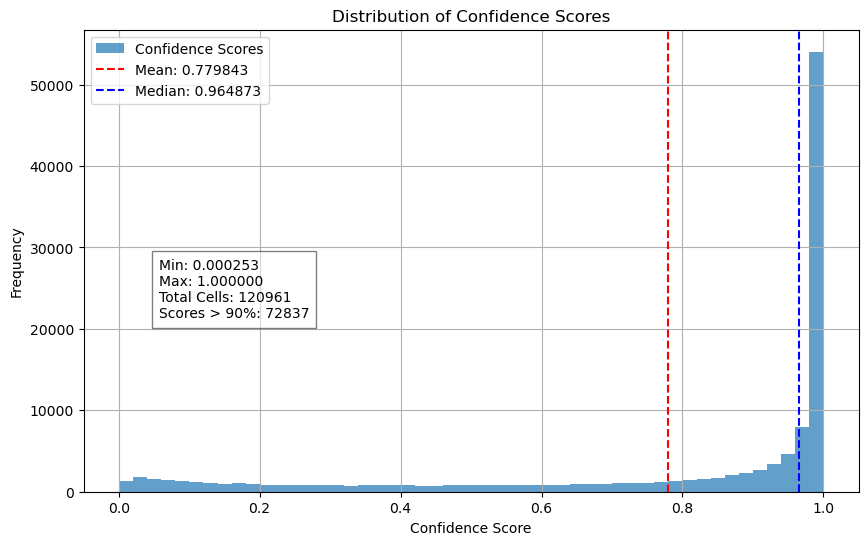

In [10]:
# Calculate mean, median, and total number of cells
mean_conf_score = adata.obs['M1_conf_score'].mean()
median_conf_score = adata.obs['M1_conf_score'].median()
total_cells = adata.obs['M1_conf_score'].shape[0]

# Plot histogram
adata.obs['M1_conf_score'].hist(bins=50, figsize=(10, 6), alpha=0.7, label='Confidence Scores')
plt.axvline(mean_conf_score, color='red', linestyle='dashed', linewidth=1.5, label=f'Mean: {mean_conf_score:.6f}')
plt.axvline(median_conf_score, color='blue', linestyle='dashed', linewidth=1.5, label=f'Median: {median_conf_score:.6f}')
plt.title('Distribution of Confidence Scores')
plt.xlabel('Confidence Score')
plt.ylabel('Frequency')
plt.legend()

# Display summary metrics
num_scores_above_90 = (adata.obs['M1_conf_score'] > 0.9).sum()
summary_text = (
    f"Min: {adata.obs['M1_conf_score'].min():.6f}\n"
    f"Max: {adata.obs['M1_conf_score'].max():.6f}\n"
    f"Total Cells: {total_cells}\n"
    f"Scores > 90%: {num_scores_above_90}"
)
plt.figtext(0.2, 0.4, summary_text, fontsize=10, bbox={"facecolor": "white", "alpha": 0.5, "pad": 5})

plt.show()

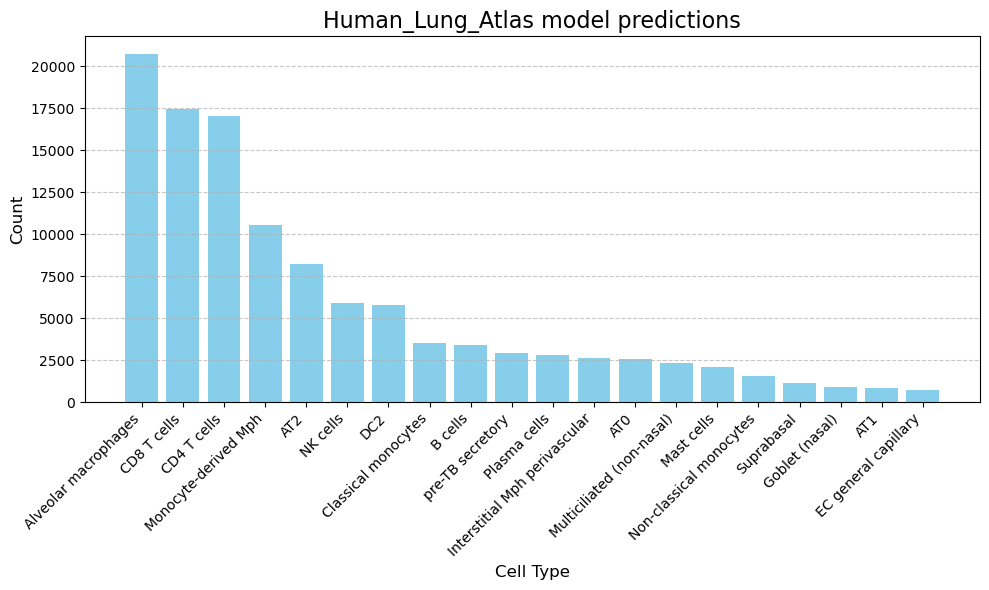

In [21]:

cell_type_counts = adata.obs["M1_predicted_labels"].value_counts().reset_index()
cell_type_counts.columns = ["Cell Type MV", "Count"]
cell_type_counts = cell_type_counts.head(20)
# Create the plot
plt.figure(figsize=(10, 6))
plt.bar(cell_type_counts["Cell Type MV"], cell_type_counts["Count"], color='skyblue')
plt.title("Human_Lung_Atlas model predictions", fontsize=16)
plt.xlabel("Cell Type", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

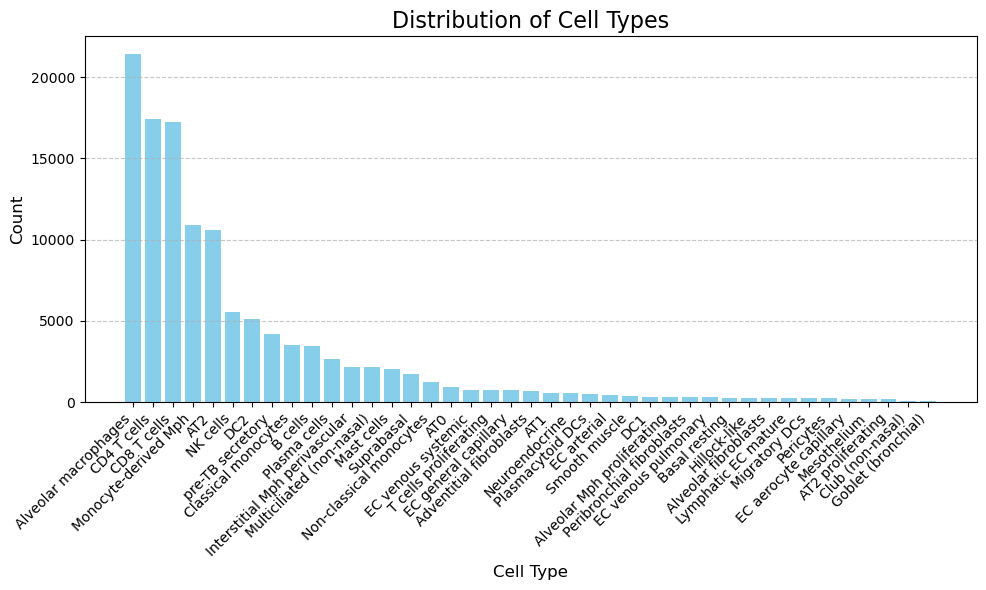

In [11]:
cell_type_counts = adata.obs["M1_majority_voting"].value_counts().reset_index()
cell_type_counts.columns = ["Cell Type MV", "Count"]

# Create the plot
plt.figure(figsize=(10, 6))
plt.bar(cell_type_counts["Cell Type MV"], cell_type_counts["Count"], color='skyblue')
plt.title("Distribution of Cell Types", fontsize=16)
plt.xlabel("Cell Type", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

## Results for the  "Cells_Lung_Airway.pkl" model

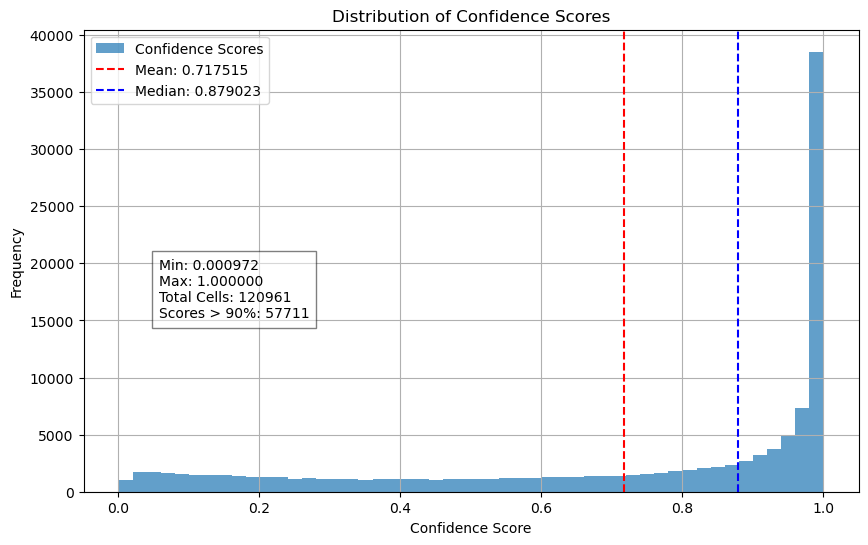

In [12]:
# Calculate mean, median, and total number of cells
mean_conf_score = adata.obs['M2_conf_score'].mean()
median_conf_score = adata.obs['M2_conf_score'].median()
total_cells = adata.obs['M2_conf_score'].shape[0]

# Plot histogram
adata.obs['M2_conf_score'].hist(bins=50, figsize=(10, 6), alpha=0.7, label='Confidence Scores')
plt.axvline(mean_conf_score, color='red', linestyle='dashed', linewidth=1.5, label=f'Mean: {mean_conf_score:.6f}')
plt.axvline(median_conf_score, color='blue', linestyle='dashed', linewidth=1.5, label=f'Median: {median_conf_score:.6f}')
plt.title('Distribution of Confidence Scores')
plt.xlabel('Confidence Score')
plt.ylabel('Frequency')
plt.legend()

# Display summary metrics
num_scores_above_90 = (adata.obs['M2_conf_score'] > 0.9).sum()
summary_text = (
    f"Min: {adata.obs['M2_conf_score'].min():.6f}\n"
    f"Max: {adata.obs['M2_conf_score'].max():.6f}\n"
    f"Total Cells: {total_cells}\n"
    f"Scores > 90%: {num_scores_above_90}"
)
plt.figtext(0.2, 0.4, summary_text, fontsize=10, bbox={"facecolor": "white", "alpha": 0.5, "pad": 5})

plt.show()

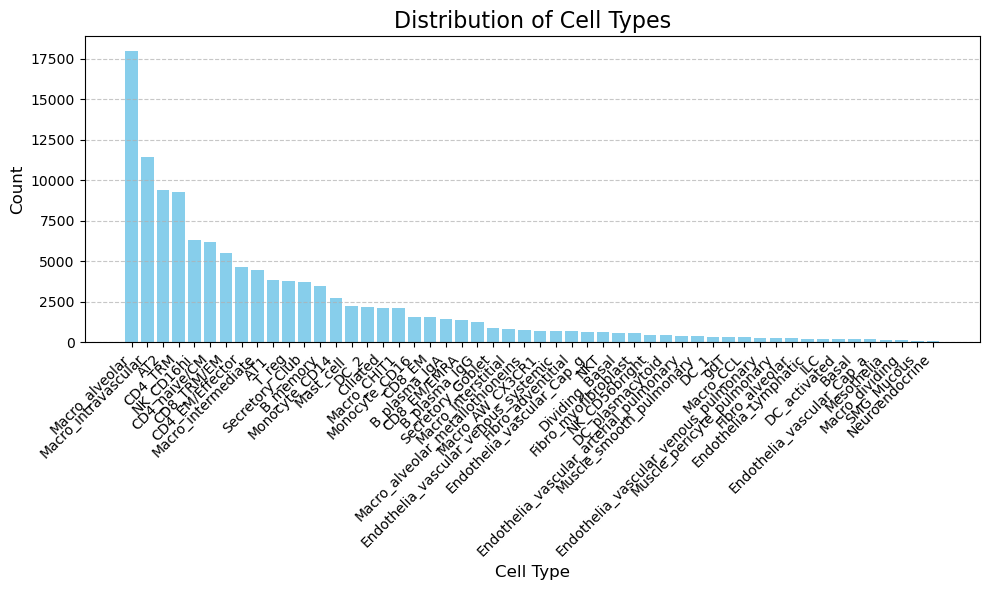

In [13]:
cell_type_counts = adata.obs["M2_majority_voting"].value_counts().reset_index()
cell_type_counts.columns = ["Cell Type MV", "Count"]

# Create the plot
plt.figure(figsize=(10, 6))
plt.bar(cell_type_counts["Cell Type MV"], cell_type_counts["Count"], color='skyblue')
plt.title("Distribution of Cell Types", fontsize=16)
plt.xlabel("Cell Type", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

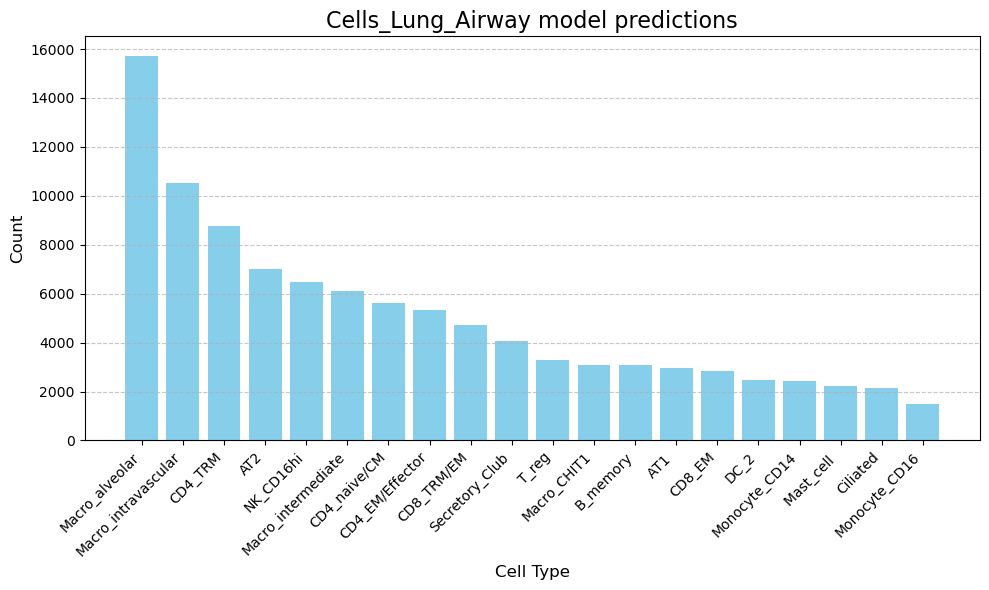

In [ ]:
cell_type_counts = adata.obs["M2_predicted_labels"].value_counts().reset_index()
cell_type_counts.columns = ["Cell Type MV", "Count"]
cell_type_counts = cell_type_counts.head(20)
# Create the plot
plt.figure(figsize=(10, 6))
plt.bar(cell_type_counts["Cell Type MV"], cell_type_counts["Count"], color='skyblue')
plt.title("Cells_Lung_Airway model predictions", fontsize=16)
plt.xlabel("Cell Type", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


## Relation
We compare the two predictions using a dotplot and notice that they do not correspond well to each other. We suspect that this is due to bad results at least using the Lung_Atlas_Model.

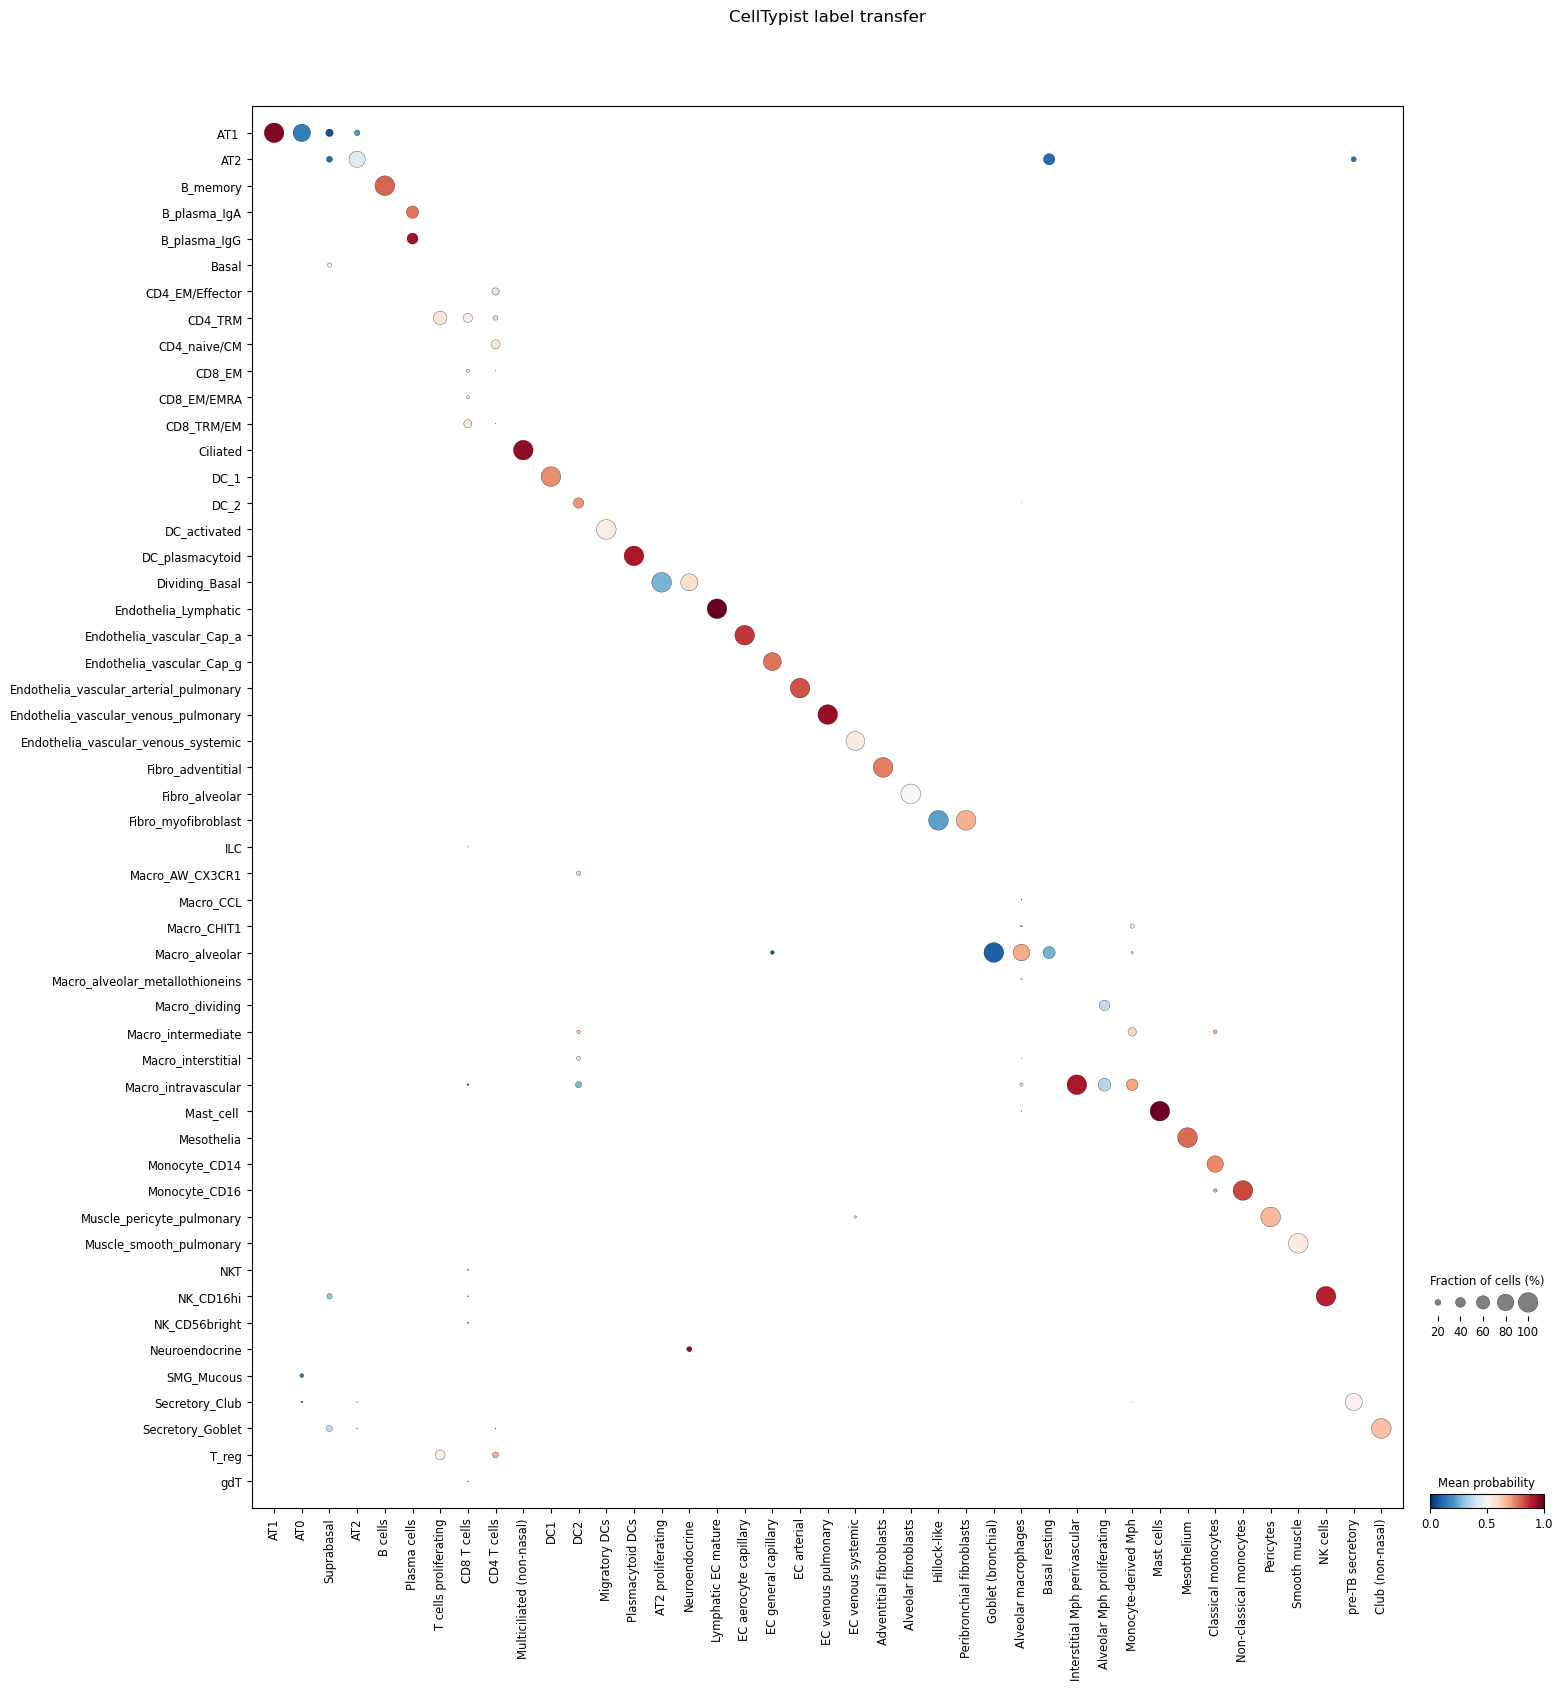

In [15]:
celltypist.dotplot(predictions2, use_as_reference = 'M1_majority_voting', use_as_prediction = 'majority_voting')

# Thesis outputs

In [16]:
csv_path = './Celltypist_confidence_scores.csv'
model_name = 'ScRef'
# Save the whole array of confidence scores as a new column in the CSV, named after the model
conf_scores = adata.obs['M2_conf_score']
csv_path = './Celltypist_confidence_scores.csv'
df_csv = pd.read_csv(csv_path)
# Ensure the lengths match before assignment
if len(df_csv) == len(conf_scores):
    df_csv[model_name] = conf_scores.values
else:
    print(f"Length mismatch: df_csv has {len(df_csv)} rows, conf_scores has {len(conf_scores)} rows.")
    # Fill the remaining rows with NaN for the new column
    df_csv[model_name] = pd.Series(conf_scores.values).reindex(df_csv.index)
print(df_csv.head())

Length mismatch: df_csv has 1300000 rows, conf_scores has 120961 rows.
     Bin8x8  Bin2Cell     Enact      Xseg    Tonsil     ScRef
0  0.173920  0.415195  0.062796  0.043314  0.065704  0.219440
1  0.111783  0.308685  0.028867  0.896519  0.417705  0.999260
2  0.653658  0.219721  0.031286  0.397644  0.263028  0.970444
3  0.790891  0.318133  0.050490  0.229899  0.068869  0.946018
4  0.189795  0.124476  0.199702  0.662286  0.039881  0.973019


In [17]:
#df_csv.to_csv(csv_path, index=False)